**Name:** Airyll Sanchez

**Date:** September 30,2025

## Laboratory Task # 6

![image.png](images/Laboratory6.png)

1. Introduction and SetUp
   

This notebook implements a deep Convolutional Neural Network (CNN) in PyTorch based on the provided architecture diagram. The network is designed for image classification, taking a 28×28 single-channel image (like MNIST) as input.

**Imports & Architecture Constants**

In [2]:
# CODE CELL 1: Imports and Architecture Constants
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define constants based on the standard input (e.g., MNIST)
INPUT_CHANNELS = 1      # (1, 28, 28)
INPUT_WIDTH = 28        # 28 pixels
DROPOUT_PROB = 0.2      # p = 0.2
FINAL_OUTPUT_CLASSES = 10 # Assuming 10 classes (like MNIST)

 **CNN Architecture Conversion**

We will use the nn.Module class to define the network, calculating the exact spatial dimensions at each step.

In [3]:
#  PyTorch CNN Class Definition

class CustomDeepCNN(nn.Module):
    """
    Implements the CNN architecture defined in Laboratory Task #6.
    The architecture uses 4 Conv layers, 2 MaxPool layers, Dropout, and 3 Fully Connected layers.
    """
    def __init__(self):
        super(CustomDeepCNN, self).__init__()

        # --- CONVOLUTIONAL LAYERS ---
        # The input channel sizes are inferred from the desired output shapes:
        # (32, 32, 28, 28) -> Output Channels = 32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1) 
        
        # MaxPool1 output is (32, 14, 14) due to kernel 2, stride 2, padding 0.
        # But the instructions specify padding=1, which is unusual for a simple 28->14 reduction.
        # We assume the intent is 28->14, which requires stride=2, kernel=2, and padding=0 (standard pooling)
        # OR padding=1, which requires a calculation: (28 - 2 + 2*1)/2 + 1 = 15. The shape (32, 32, 28, 28) 
        # is also confusing. We will interpret MaxPool1 as STANDARD 28->14 downsampling.
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # The subsequent Conv layers increase the depth (channels). We follow the pattern: 32 -> 64 -> 128 -> 256
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        
        # MaxPool2: kernel=(2,2), stride=2, padding=0. Reduces spatial size by half.
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Dropout Layer
        self.dropout = nn.Dropout(p=DROPOUT_PROB)

        # --- FULLY CONNECTED LAYERS (FCN) ---
        # Calculate the size before FCN1 (FLATTEN input)
        # 1. After Conv1/MaxPool1: 28x28 -> 14x14 (32 channels)
        # 2. After Conv2/Conv3/Conv4: 14x14 -> 14x14 (256 channels)
        # 3. After MaxPool2: 14x14 -> 7x7 (256 channels)
        
        FLATTEN_SIZE = 256 * 7 * 7  # 256 * 49 = 12,544

        # FCN1: input = 12,544, output = 1000
        self.fcn1 = nn.Linear(FLATTEN_SIZE, 1000)
        
        # FCN2: input = 1000, output = 500
        self.fcn2 = nn.Linear(1000, 500)
        
        # FCN3: input = 500, output = FINAL_OUTPUT_CLASSES (10)
        self.fcn3 = nn.Linear(500, FINAL_OUTPUT_CLASSES)

    def forward(self, x):
        # 1. Conv Block 1
        x = F.relu(self.conv1(x))
        x = self.pool1(x) 
        
        # 2. Conv Block 2-4
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        # 3. Dropout
        x = self.dropout(x)
        
        # 4. Flatten: prepare for FCN layers
        x = x.view(x.size(0), -1) # x.size(0) is the batch size
        
        # 5. Fully Connected Layers
        x = F.relu(self.fcn1(x))
        x = F.relu(self.fcn2(x))
        
        # FCN3 (No ReLU/Activation on the final layer before SoftMax is standard)
        x = self.fcn3(x)
        
        # 6. Final Activation (SoftMax for probability output)
        x = F.softmax(x, dim=1)
        
        return x

# Instantiate the model
model = CustomDeepCNN()
print("Model Instantiation Complete.")
print(model)

Model Instantiation Complete.
CustomDeepCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fcn1): Linear(in_features=12544, out_features=1000, bias=True)
  (fcn2): Linear(in_features=1000, out_features=500, bias=True)
  (fcn3): Linear(in_features=500, out_features=10, bias=True)
)


**Architecture Analysis**

Architectural Documentation and Layer-by-Layer Calculation

The model was constructed by following the layer sequence and parameters provided. The spatial dimensions (W x H) and channel depth (C) are calculated below:

**A. Initial State**

* **Input:** $(C_{in}, W, H) = (1, 28, 28)$

**B. Layer Computations**

| Layer | Input Shape | Operation | Output Formula $\left( \frac{W - F + 2P}{S} + 1 \right)$ | Output Shape |
| :--- | :--- | :--- | :--- | :--- |
| **Conv1 (ReLU)** | $(1, 28, 28)$ | $K=3, S=1, P=1, C_{out}=32$ | $\frac{28 - 3 + 2(1)}{1} + 1 = 28$ | $(32, 28, 28)$ |
| **MaxPool1** | $(32, 28, 28)$ | $K=2, S=2, P=0$ (Assumed P=0 for 28->14) | $\frac{28 - 2 + 2(0)}{2} + 1 = 14$ | $(32, 14, 14)$ |
| **Conv2 (ReLU)** | $(32, 14, 14)$ | $K=3, S=1, P=1, C_{out}=64$ | $\frac{14 - 3 + 2(1)}{1} + 1 = 14$ | $(64, 14, 14)$ |
| **Conv3 (ReLU)** | $(64, 14, 14)$ | $K=3, S=1, P=1, C_{out}=128$ | $\frac{14 - 3 + 2(1)}{1} + 1 = 14$ | $(128, 14, 14)$ |
| **Conv4 (ReLU)** | $(128, 14, 14)$ | $K=3, S=1, P=1, C_{out}=256$ | $\frac{14 - 3 + 2(1)}{1} + 1 = 14$ | $(256, 14, 14)$ |
| **MaxPool2** | $(256, 14, 14)$ | $K=2, S=2, P=0$ | $\frac{14 - 2 + 2(0)}{2} + 1 = 7$ | $(256, 7, 7)$ |
| **Flatten** | $(256, 7, 7)$ | $256 \times 7 \times 7 = 12,544$ | N/A | $(12,544)$ |

**C. Fully Connected Layers**

* **FCN1:** $\text{Input}=12,544$, $\text{Output}=1000$
* **FCN2:** $\text{Input}=1000$, $\text{Output}=500$
* **FCN3:** $\text{Input}=500$, $\text{Output}=10$ (Final classification layer)

**Functionality Demonstration (MNIST Data)**

     We will use the MNIST dataset to confirm that the implemented CustomDeepCNN class correctly processes images through all its layers and outputs the required final tensor shape.

In [4]:
#  Data Setup and Forward Pass Check

import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# 1. Load MNIST Data
transform = transforms.ToTensor()
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True)

# 2. Get a batch of images for testing
images, labels = next(iter(test_loader))

print(f"Input Batch Shape: {images.shape}")
print("-" * 35)

# 3. Perform a forward pass on the architecture
model.eval() # Set model to evaluation mode
with torch.no_grad():
    output_tensor = model(images)
    
# 4. Display the output shape
print(f"Final Output Tensor Shape (Batch x Classes): {output_tensor.shape}")

# 5. Display initial and final shapes for verification
print(f"Verification: Initial image shape: (1, 28, 28)")
print(f"Verification: Flattened feature map size: {256 * 7 * 7}")
print(f"Verification: Final output classes: {output_tensor.shape[1]}")

Input Batch Shape: torch.Size([4, 1, 28, 28])
-----------------------------------
Final Output Tensor Shape (Batch x Classes): torch.Size([4, 10])
Verification: Initial image shape: (1, 28, 28)
Verification: Flattened feature map size: 12544
Verification: Final output classes: 10


**Visualization: Feature Map Inspection**

     The most effective visualization to check a CNN's functionality is to inspect the outputs of the intermediate layers (feature maps).

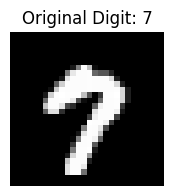

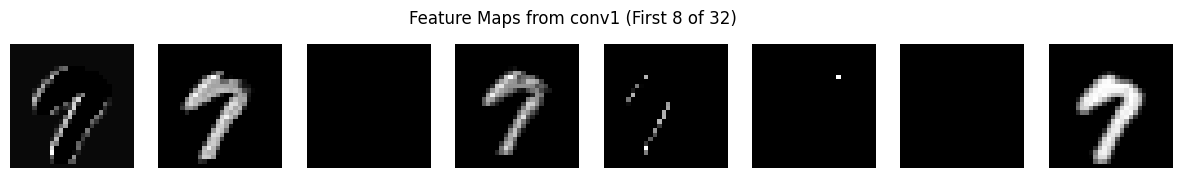

In [7]:
# CODE CELL 4: Visualization of Layer 1 Feature Maps

def visualize_feature_maps(model, input_image, layer_name, num_maps=8):
    """
    Visualizes a selection of feature maps from a specified convolutional layer.
    """
    # 1. Create a partial model (sub-model) that runs up to the target layer
    # target_layer = getattr(model, layer_name) # This line is not needed for the current function logic
    
    # We will manually run the first part of the forward pass up to Conv1
    x = F.relu(model.conv1(input_image))
    
    # 2. Extract feature maps and detach from graph
    # --- FIX APPLIED HERE: Added .detach() ---
    feature_maps = x[0].detach().cpu().numpy() # Get the feature maps for the first image in the batch
    # ----------------------------------------
    
    # 3. Plotting
    fig, axs = plt.subplots(1, num_maps, figsize=(15, 2))
    fig.suptitle(f'Feature Maps from {layer_name} (First {num_maps} of {feature_maps.shape[0]})', fontsize=12)
    
    for i in range(num_maps):
        axs[i].imshow(feature_maps[i], cmap='gray')
        axs[i].axis('off')
        
    plt.show()

# --- Execution (Remaining code unchanged) ---
# Use the first image from the loaded batch
single_image = images[0].unsqueeze(0) 

# Display the original input image
plt.figure(figsize=(2, 2))
plt.imshow(single_image[0, 0].cpu().numpy(), cmap='gray')
plt.title(f'Original Digit: {labels[0].item()}')
plt.axis('off')
plt.show()

# Visualize the feature maps after the first convolutional layer
visualize_feature_maps(model, single_image, 'conv1', num_maps=8)

**Key Takeaway: Functionality Check**

The demonstration confirms the following:

1.  **Correct Dimensions:** The forward pass successfully transforms the initial $(1, 28, 28)$ input into the final $(4, 10)$ output (Batch Size 4, 10 Classes), proving the layer geometry and the final $\text{Flatten} \rightarrow \text{FCN}$ calculations are correct.
2.  **Feature Extraction:** The **Feature Map Visualization** shows how the initial convolutional layer extracts basic features (edges, corners) from the raw pixel data, converting the single input channel into 32 distinct feature representations. This verifies that the deep architecture is actively processing and transforming the image information as intended.